# EYE FOR BLIND
##### By Mahalakshmi Totad

**Problem statement**: In this capstone project,goal is to create a deep learning model which can explain the contents of an image in the form of speech through caption generation with an attention mechanism. This kind of model is a use-case for blind people so that they can understand any image with the help of speech. The caption generated through a CNN-RNN model will be converted to speech using a text to speech library. 

**The dataset** is Flickr8K, it is taken from the Kaggle website and it consists of sentence-based image descriptions having a list of 8,000 images that are each paired with five different captions which provide clear descriptions of the salient entities and events of the image.

**The major steps to perform can be briefly summarised in the following four steps:**

- **Data Understanding:**  load the data and understand the representation.
- **Data Preprocessing:** In this step, process both images and captions to the desired format.
- **Train-Test Split:** Combine both images and captions to create the train and test dataset.
- **Model Building:** This is the stage to create image captioning model by building Encoder, Attention and Decoder model.
- **Model Evaluation:** Evaluate the models using greedy search and BLEU score.

In [1]:
# Install all the required libraries

In [4]:
!pip3 install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 520.1/520.1 KB 2.7 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [128]:
!pip install gTTs
!pip install playsound

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
  Preparing metadata (setup.py) ... done
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7035 sha256=fb8d1a993f7ad7c0dbb2a2bc9a5efef041c353d967d89601d34df2bf7de9ee96
  Stored in directory: /home/.cache/pip/wheels/73/cd/cf/9750b618d54bd81c20e4c34fb24a423a5b095920367cdb3f71
Successfully built playsound
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [4]:
#Import all the required libraries
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

from skimage import io
pd.set_option('display.max_colwidth',None) # Set the max column width to see the complete caption

In [5]:
import collections
from collections import Counter

In [6]:
from wordcloud import WordCloud,STOPWORDS

In [7]:
import tensorflow as tf
import keras
from keras.preprocessing.image import load_img
import string
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [8]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Input
from tqdm import tqdm
from PIL import Image


In [ ]:
from gtts import gTTS
from playsound import playsound
from IPython import display

## Step 1 : Data Understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions


#### Let's read the dataset

In [11]:
#Import the dataset and read the image into a seperate variable

images='datasets/flickr/Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


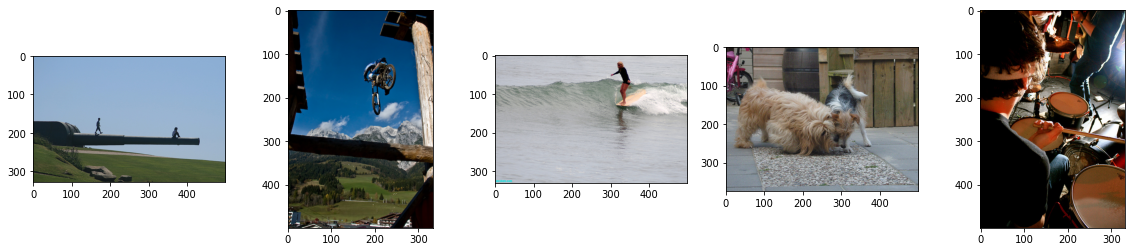

In [12]:
#Visualise both the images & text present in the dataset

Display_Images= all_imgs[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)
   
for ax,image in zip(axes, Display_Images):
    ax.imshow(io.imread(image), cmap=None)

In [13]:
#Import the dataset and read the text file into a seperate variable

text_file = 'datasets/flickr/captions.txt'

def load_doc(text_file):
    
    #your code here
    # Read the captions file
    with open(text_file, 'r') as file:
        text = file.readlines()
    
    return text

doc = load_doc(text_file)
print(doc[:300])

['image,caption\n', '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n', '1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n', '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n', '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n', '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n', '1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n', '1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .\n', '1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .\n', '1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .\n', '1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .\n', '1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted

### Create a dataframe which summarizes the image, path & captions as a dataframe

- Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [ ]:
#template
# all_img_id= #store all the image id here
# all_img_vector= #store all the image path here
# annotations= #store all the captions here

# df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
# df

In [15]:
image_path='datasets/flickr/Images/'
all_img_id=[]  #store all the image id here
all_img_vector=[] #store all the image path here
annotations= []#store all the captions here

# Path to the captions file
captions_file_path = 'datasets/flickr/captions.txt'

# Read and process the captions file
with open(captions_file_path, 'r') as file:
    lines = file.readlines()
    for line in lines:
        img_name, caption = line.strip().split(',', 1)  # Split only on the first comma
        all_img_id.append(img_name)  # Store the image name
        all_img_vector.append(f'{image_path}{img_name}')  # Store the full image path
        annotations.append(caption.strip())  # Store the caption

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 

In [16]:
df.shape

(40456, 3)

In [17]:
df = df.drop(0).reset_index(drop=True)

In [18]:
df.head(5)

ID  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                               Path  \
0  datasets/flickr/Images/1000268201_693b08cb0e.jpg   
1  datasets/flickr/Images/1000268201_693b08cb0e.jpg   
2  datasets/flickr/Images/1000268201_693b08cb0e.jpg   
3  datasets/flickr/Images/1000268201_693b08cb0e.jpg   
4  datasets/flickr/Images/1000268201_693b08cb0e.jpg   

                                                                   Captions  
0  A child in a pink dress is climbing up a set of stairs in an entry way .  
1                                     A girl going into a wooden building .  
2                          A little girl climbing into a wooden playhouse .  
3                      A little girl climbing the stairs to her playhouse .  
4                 A little girl in a pink dress going into a wooden cabin .

In [19]:
df.shape

(40455, 3)

In [20]:
# Path to the captions file
captions_file_path = 'datasets/flickr/captions.txt'
image_path = 'datasets/flickr/Images/'

#Create a list which contains all the captions
annotations= []#write your code here

#Create a list which contains all the path to the images
all_img_path= [] #write your code here

#add the <start> & <end> token to all those captions as well
caption_with_tokens = f'<start> {caption.strip()} <end>'

with open(captions_file_path, 'r') as file:
    lines = file.readlines()
    for line in lines:
        img_name, caption = line.strip().split(',', 1)  # Split only on the first comma
        caption_with_tokens = f'<start> {caption.strip()} <end>'  # Add <start> and <end> tokens
        annotations.append(caption_with_tokens)  # Store the caption with tokens
        all_img_path.append(f'{image_path}{img_name}')  # Store the full image path
        

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40456
Total images present in the dataset: 40456


In [21]:
#Create the vocabulary & the counter for the captions

vocabulary= []#write your code here

for caption in annotations:
    words = caption.lower().split()
    vocabulary.extend(words)
    
val_count=Counter(vocabulary)
val_count

Counter({'<start>': 40456,
         'caption': 1,
         '<end>': 40456,
         'a': 61752,
         'child': 1535,
         'in': 18965,
         'pink': 735,
         'dress': 347,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6712,
         'stairs': 109,
         'an': 2399,
         'entry': 1,
         'way': 50,
         '.': 34212,
         'girl': 3320,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 509,
         'little': 1754,
         'playhouse': 6,
         'the': 18249,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3825,
         'dog': 8126,
         'and': 8851,
         'spotted': 37,
         'are': 3504,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'with': 7761,
         'each': 430,
         'other': 772,
         'on': 10732,
         'road': 388,
         'white': 3935,
         '

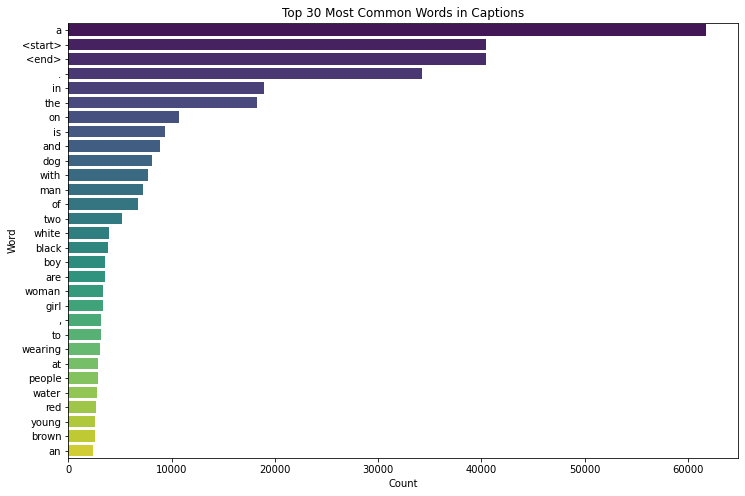

In [22]:
#Visualise the top 30 occuring words in the captions


#write your code here
# Get the 30 most common words
top_30_words = val_count.most_common(30)

# Split the words and counts into separate lists
words, counts = zip(*top_30_words)

# Plot the data
plt.figure(figsize=(12, 8))
sns.barplot(x=list(counts), y=list(words), palette='viridis')
plt.xlabel('Count')
plt.ylabel('Word')
plt.title('Top 30 Most Common Words in Captions')
plt.show()

In [10]:
# wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(val_count)
# plt.figure(figsize=(8,8))
# plt.imshow(wordcloud)

### Filtering out the stop words to see top 30 words

In [24]:
filtered_vocabulary = [word for word in val_count if word not in STOPWORDS]

filtered_vocabulary = [word for word in val_count if word not in ['<start>','<end>']]


# Create a Counter for the filtered vocabulary
filtered_val_count = Counter(filtered_vocabulary)

# Get the 30 most common words excluding stopwords
top_30_filtered_words = filtered_val_count.most_common(30)

# Split the words and counts into separate lists
words, counts = zip(*top_30_filtered_words)

In [25]:
# wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(filtered_val_count)
# plt.figure(figsize=(8,8))
# plt.imshow(wordcloud)

### Visualize images and their respective captions

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


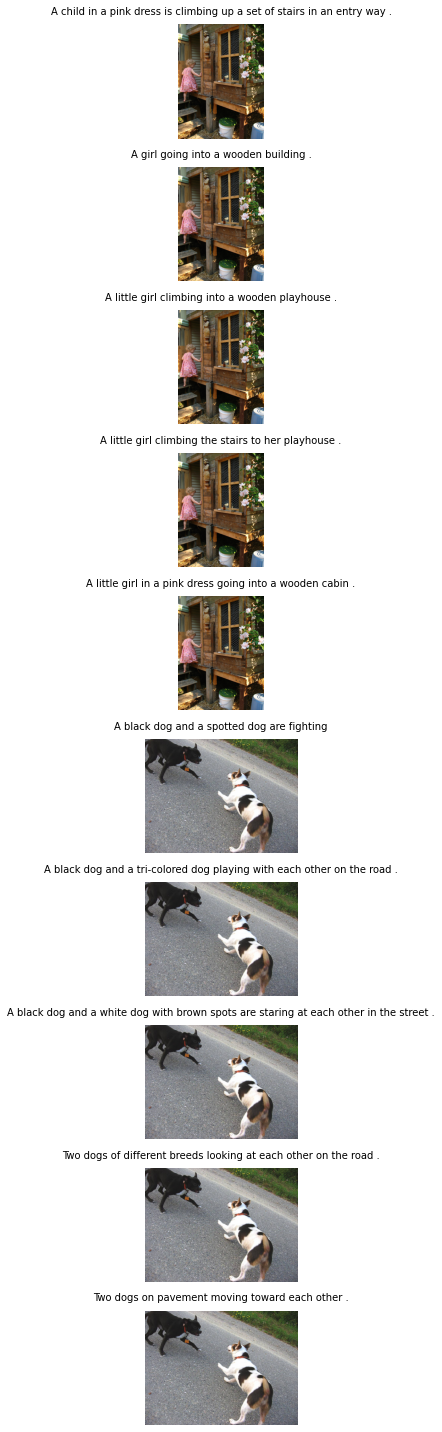

In [27]:

# Number of images to display
num_images = min(10, len(df))  # Display up to 10 images, or less if the DataFrame has fewer rows

# Create a grid of subplots
fig, axes = plt.subplots(nrows=num_images, ncols=1, figsize=(10, 20))

for i in range(num_images):
    ax = axes[i]
    img_path = df.iloc[i]['Path']
    caption = df.iloc[i]['Captions']
    
    # Read and display the image
    img = mpimg.imread(img_path)
    ax.imshow(img)
    
    # Remove axis
    ax.axis('off')
    
    # Set the caption
    ax.set_title(caption, fontsize=10, pad=10)

# Adjust layout
plt.tight_layout()
plt.show()

## Step 2 : Data Preprocessing

### Data Cleaning

In [28]:
print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40456
Total images present in the dataset: 40456


In [29]:
annotations[0:5]

['<start> caption <end>',
 '<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> A girl going into a wooden building . <end>',
 '<start> A little girl climbing into a wooden playhouse . <end>',
 '<start> A little girl climbing the stairs to her playhouse . <end>']

In [30]:
# type(annotations)
annotations.pop(0)

'<start> caption <end>'

In [31]:
annotations[0:5]
print("Total captions present in the dataset: "+ str(len(annotations)))

Total captions present in the dataset: 40455


In [32]:
all_img_path[0:5]

['datasets/flickr/Images/image',
 'datasets/flickr/Images/1000268201_693b08cb0e.jpg',
 'datasets/flickr/Images/1000268201_693b08cb0e.jpg',
 'datasets/flickr/Images/1000268201_693b08cb0e.jpg',
 'datasets/flickr/Images/1000268201_693b08cb0e.jpg']

In [33]:
all_img_path.pop(0)

'datasets/flickr/Images/image'

In [34]:
print("Total images present in the dataset: " + str(len(all_img_path)))

Total images present in the dataset: 40455


In [63]:
all_img_vector[0]

'datasets/flickr/Images/image'

In [64]:
all_img_vector.pop(0)

'datasets/flickr/Images/image'

In [66]:
all_img_vector[0]

'datasets/flickr/Images/1000268201_693b08cb0e.jpg'

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [35]:
# create the tokenizer

#your code here
tokenizer = Tokenizer(
    num_words=5000,
    filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',
    lower=True,
    oov_token="<UNK>"
)

# annotations
tokenizer.fit_on_texts(annotations)

In [36]:
# Create word-to-index and index-to-word mappings.

#your code here
#Using tokenizer to 'Transforms text to a sequence of integers'
train_seqs = tokenizer.texts_to_sequences(annotations) 

#Since we are going to add padding, manually defining word to index and index to word for <pad> tag
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'



In [37]:
print(tokenizer.oov_token)
print(tokenizer.index_word[0])

<UNK>
<pad>


In [38]:
print(tokenizer.index_word)

{1: '<UNK>', 2: 'a', 3: '<start>', 4: '<end>', 5: 'in', 6: 'the', 7: 'on', 8: 'is', 9: 'and', 10: 'dog', 11: 'with', 12: 'man', 13: 'of', 14: 'two', 15: 'white', 16: 'black', 17: 'boy', 18: 'are', 19: 'woman', 20: 'girl', 21: 'to', 22: 'wearing', 23: 'at', 24: 'people', 25: 'water', 26: 'red', 27: 'young', 28: 'brown', 29: 'an', 30: 'his', 31: 'blue', 32: 'dogs', 33: 'running', 34: 'through', 35: 'playing', 36: 'while', 37: 'shirt', 38: 'down', 39: 'standing', 40: 'ball', 41: 'little', 42: 'grass', 43: 'snow', 44: 'child', 45: 'person', 46: 'jumping', 47: 'over', 48: 'three', 49: 'front', 50: 'sitting', 51: 'holding', 52: 'up', 53: 'field', 54: 'small', 55: 'by', 56: 'large', 57: 'green', 58: 'one', 59: 'group', 60: 'yellow', 61: 'her', 62: 'walking', 63: 'children', 64: 'men', 65: 'into', 66: 'air', 67: 'beach', 68: 'near', 69: 'mouth', 70: 'jumps', 71: 'another', 72: 'for', 73: 'street', 74: 'runs', 75: 'its', 76: 'from', 77: 'riding', 78: 'stands', 79: 'as', 80: 'bike', 81: 'girls',

In [39]:
# checking the count of <start> <end> tokens and other words
tokenizer.word_counts

OrderedDict([('<start>', 40455),
             ('a', 62992),
             ('child', 1545),
             ('in', 18986),
             ('pink', 739),
             ('dress', 348),
             ('is', 9345),
             ('climbing', 507),
             ('up', 1302),
             ('set', 109),
             ('of', 6723),
             ('stairs', 109),
             ('an', 2432),
             ('entry', 1),
             ('way', 53),
             ('<end>', 40455),
             ('girl', 3328),
             ('going', 149),
             ('into', 1074),
             ('wooden', 284),
             ('building', 510),
             ('little', 1768),
             ('playhouse', 6),
             ('the', 18419),
             ('to', 3176),
             ('her', 1178),
             ('cabin', 4),
             ('black', 3848),
             ('dog', 8138),
             ('and', 8862),
             ('spotted', 38),
             ('are', 3504),
             ('fighting', 133),
             ('tri', 14),
             ('color

<start> :  40455
<end> :  40455
a :  40271
. :  34212
A :  21481
in :  18961
the :  15328
on :  10729
is :  9345
and :  8850
dog :  7982
with :  7760
man :  6828
of :  6712
Two :  3962
white :  3875
black :  3696
are :  3503
boy :  3442
woman :  3227
girl :  3217
, :  3210
to :  3173
wearing :  3061
The :  2920
at :  2904
water :  2774
red :  2660
brown :  2475
people :  2442


/tmp/ipykernel_221/2390932587.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


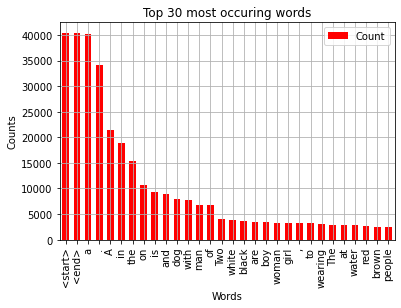

In [40]:
# Visualization of top 30 words after tokenization


#your code here
tokenizer_top_words= [word for line in annotations for word in line.split()]

tokenizer_top_words_count=collections.Counter(tokenizer_top_words)
tokenizer_top_words_count

for word, count in tokenizer_top_words_count.most_common(30):
    print(word, ": ", count)

token_lst = tokenizer_top_words_count.most_common(30)
most_common_words_df = pd.DataFrame(token_lst, columns = ['Word', 'Count'])
most_common_words_df.plot.bar(x='Word',y='Count',width=0.6,color='red')
plt.title("Top 30 most occuring words")
plt.xlabel("Words")
plt.ylabel("Counts")
plt.grid(b=None)

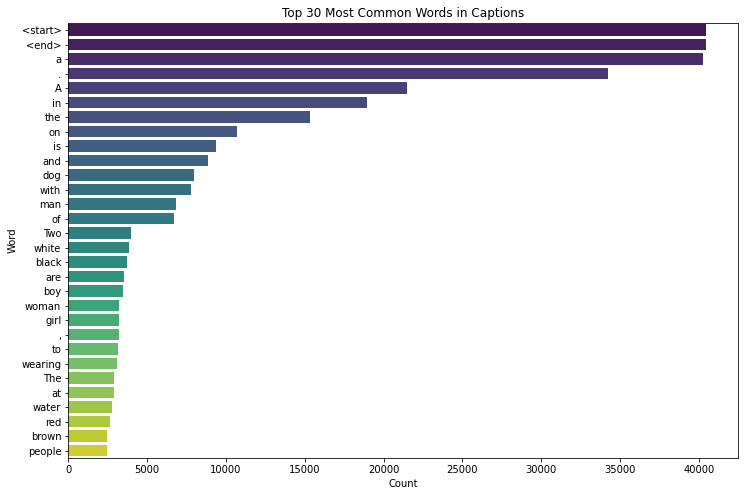

In [41]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

#your code here
tokenizer_top_words= [word for line in annotations for word in line.split()]

tokenizer_top_words_count= Counter(tokenizer_top_words)
tokenizer_top_words_count


# Get the 30 most common words
top_30_words = tokenizer_top_words_count.most_common(30)

# Split the words and counts into separate lists
words, counts = zip(*top_30_words)

# Plot the data
plt.figure(figsize=(12, 8))
sns.barplot(x=list(counts), y=list(words), palette='viridis')
plt.xlabel('Count')
plt.ylabel('Word')
plt.title('Top 30 Most Common Words in Captions')
plt.show()

In [43]:
# wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(filtered_val_count)
# plt.figure(figsize=(8,8))
# plt.imshow(wordcloud)

### Padding
- Using Tensorflow sequence to pad the caption using max length parameter

In [47]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [49]:
print(tf.__version__)

2.7.0


In [50]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
# train_seqs

#find length of all captions in the list
train_seqs_len=[len(seq) for seq in train_seqs] 
#find maximum value of length from list
max_length= max(train_seqs_len) 

#your code here
cap_vector= pad_sequences(
    train_seqs,
    maxlen=max_length,
    dtype='int32',
    padding='post',
    value=0.0
)

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### Steps taken to resize the images::
* Since we have a list which contains all the image path, we need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once we have created a dataset consisting of image paths, we need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [ ]:
#write your code here to create the dataset consisting of image paths

In [52]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path
# all_imgs


img_data = tf.data.Dataset.from_tensor_slices(all_imgs)
img_data = img_data.map(load_image).batch(32)

2024-08-19 16:13:10.802542: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-08-19 16:13:10.802635: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


In [51]:
#write your code here for creating the function. This function should return images & their path
IMAGE_SHAPE= (299, 299)

def load_image(image_path):
    #write your pre-processing steps here
    #read image
    img = tf.io.read_file(image_path,name=None)
    
    #decode and resize image
    img = tf.image.decode_jpeg(img,channels=0) 
    img = tf.image.resize(img, IMAGE_SHAPE)
    
    #preprocess input
    img = tf.keras.applications.inception_v3.preprocess_input(img,data_format=None) #Default value for data format is None

    # It refers to global setting tf.keras.backend.image_data_format()
    return img, image_path
    return 

In [53]:
type(img_data)
img_data

<BatchDataset shapes: ((None, 299, 299, None), (None,)), types: (tf.float32, tf.string)>

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [54]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output  #write code here to get the output of the image_model

image_features_extract_model = tf.compat.v1.keras.Model(new_input, hidden_layer) #build the final model using both input & output layer

87924736/87910968 [==============================] - 6s 0us/step


In [55]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)

#dataset name is 'img_data'

features_dict={}
for image, image_path in tqdm(img_data): #using tqdm as progress bar
    features_for_batch = image_features_extract_model(image) 

    #reshape images for given order of(batch_size, 8*8, 2048)
    features_for_batch_flattened = tf.reshape(features_for_batch,
                             (features_for_batch.shape[0], -1, features_for_batch.shape[3]))
                                   
    for batch_feat, path in zip(features_for_batch_flattened, image_path):
        feature_path = path.numpy().decode("utf-8")
        features_dict[feature_path] =  batch_feat.numpy()



100%|██████████| 253/253 [00:38<00:00,  6.57it/s]


In [56]:
# features_dict

In [57]:
# batch_feat

In [58]:
len(features_dict)

8091

In [59]:
batch_feat.shape

TensorShape([64, 2048])

###  Store the features:
* Store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* Store using numpy(np.save) to store the resulting vector.

## Step 3 : Train-Test Split

### Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

    1.Make sure you have done Shuffle and batch while building the dataset

    2.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

    3.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [68]:
#write your code here

path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector,cap_vector,test_size=0.2,random_state=42)

In [69]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [70]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.
# features_dict

def map_func(image_path,cap):
    img_tensor = features_dict[image_path.decode('utf-8')] # write your code here to extract the features from the dictionary stored earlier
    return img_tensor,cap

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [71]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

BUFFER_SIZE = 1000
BATCH_SIZE = 64 
AUTOTUNE = tf.data.experimental.AUTOTUNE

def gen_dataset(images_data, captions_data):
    
    # your code goes here to create the dataset & transform it
    
    # Creating a dataset
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))

    dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=AUTOTUNE)
    
    # reshuffle_each_iteration=True, batch_size=64,drop_remainder=False,Prefetch function to use AUTOTUNE
    
    dataset = (
     dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True) 
    .batch(BATCH_SIZE, drop_remainder=False)
    .prefetch(AUTOTUNE)
    ) 
    
    return dataset


In [72]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [73]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 39)


 #### As expected we were able to achieve the following
1. The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)
2. The shape of each caption in the dataset after building should be(batch_size, max_len)


## Step 4: Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [74]:
# parameters
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE


max_length=39 # as calculated previously
features_shape = batch_feat.shape[1]
attention_features_shape = batch_feat.shape[0]

### Encoder

In [75]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense =tf.keras.layers.Dense(embed_dim) #build your Dense layer with relu activation
        
    def call(self, features):
        features = self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0)
        
        return features

In [76]:
encoder=Encoder(embedding_dim)

### Attention model

In [77]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)#build your Dense layer
        self.W2 = tf.keras.layers.Dense(units)#build your Dense layer
        self.V = tf.keras.layers.Dense(1)#build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_axis=hidden[:, tf.newaxis] # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score =tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_axis))# build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.keras.activations.softmax(self.V(score), axis=1)# extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)# reduce the shape to (batch_size, embedding_dim)
        return context_vector, attention_weights

### Decoder

For tf.keras.layers.GRU
- return_sequences -> need output to be returned at every time step
- return_state -> hidden state should be returned at each time step

In [78]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units        
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim)#build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer with dimension => self.units=512 
        self.d2 = tf.keras.layers.Dense(vocab_size)   #build your Dense layer with dimension => vocab_size=5001 

        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)#create your context vector & attention weights from attention model
        embed = self.embed(x)# embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)# Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
  
        return output,state, attention_weights
    
    
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [79]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [80]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


#### We can see that we are getting expected shapes. So we can say that our encoder and decoder are setup properly.

## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [81]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) #define the optimizer
# Using crossentropy SparseCategoricalCrossentropy. It calculates loss between the labels and predictions. 
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction=tf.keras.losses.Reduction.NONE) #define your loss object


In [82]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [105]:
#save the model using checkpoint
checkpoint_path = "checkpoint/checkpoint1"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [106]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [91]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])# decoder reset_state has been depricated hence using init_state
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        
        #FEATURES FROM ENCODER
        encoder_output = encoder(img_tensor)

        # Using the teacher forcing technique where the target word is passed as the next input to the decoder
        for t in range(1, target.shape[1]):
            # passing encoder_output to the decoder
            predictions, hidden, _ = decoder(dec_input, encoder_output, hidden)
            loss += loss_function(target[:, t], predictions)
            dec_input = tf.expand_dims(target[:, t], 1)
    
    avg_loss = (loss / int(target.shape[1])) #we are calculating average loss for every batch

    #total trainable variables = encoder trainable var + decoder trainable  var
    tot_trainables_variables = encoder.trainable_variables + decoder.trainable_variables
    
    grads = tape.gradient(loss, tot_trainables_variables) # to calculate gradients with respect to every trainable variable

    #compute gradients and apply it to the optimizer and backpropagate.
    optimizer.apply_gradients(zip(grads, tot_trainables_variables)) 
    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [95]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    #hidden = decoder.reset_state(batch_size=target.shape[0]) # decoder reset_state has been depricated
    hidden = decoder.init_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape: #Record operations for automatic differentiation.
        #write your code here to do the training steps
        encoder_output = encoder(img_tensor)

        # Using the teacher forcing technique where the target word is passed as the next input to the decoder.
        for t in range(1, target.shape[1]):
          # passing encoder_output to the decoder
            predictions, hidden, _ = decoder(dec_input, encoder_output, hidden)
            loss += loss_function(target[:, t], predictions) 
            dec_input = tf.expand_dims(target[:, t], 1)
    
    avg_loss = (loss / int(target.shape[1]))#we are calculating average loss for every batch

    tot_trainables_variables = encoder.trainable_variables + decoder.trainable_variables

    grads = tape.gradient(loss, tot_trainables_variables) # to calculate gradients with respect to every trainable variable

    #compute gradients and apply it to the optimizer and backpropagate.
    optimizer.apply_gradients(zip(grads, tot_trainables_variables))
        
    return loss, avg_loss

In [93]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
        avg_test_loss=total_loss / test_num_steps

    return avg_test_loss

In [107]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  7%|▋         | 1/15 [01:23<19:32, 83.75s/it]

For epoch: 1, the train loss is 0.859, & test loss is 0.865
Time taken for 1 epoch 83.55029964447021 sec

Test loss has been reduced from 100.000 to 0.865


 13%|█▎        | 2/15 [02:53<18:53, 87.21s/it]

For epoch: 2, the train loss is 0.803, & test loss is 0.804
Time taken for 1 epoch 89.44149947166443 sec

Test loss has been reduced from 0.865 to 0.804
For epoch: 3, the train loss is 0.755, & test loss is 0.754
Time taken for 1 epoch 85.20404314994812 sec

Test loss has been reduced from 0.804 to 0.754


 20%|██        | 3/15 [04:18<17:16, 86.40s/it]

For epoch: 4, the train loss is 0.713, & test loss is 0.710
Time taken for 1 epoch 88.02638673782349 sec

Test loss has been reduced from 0.754 to 0.710


 33%|███▎      | 5/15 [07:11<14:21, 86.18s/it]

For epoch: 5, the train loss is 0.672, & test loss is 0.671
Time taken for 1 epoch 84.31807136535645 sec

Test loss has been reduced from 0.710 to 0.671
For epoch: 6, the train loss is 0.636, & test loss is 0.634
Time taken for 1 epoch 90.45857501029968 sec

Test loss has been reduced from 0.671 to 0.634


 40%|████      | 6/15 [08:42<13:09, 87.71s/it]

For epoch: 7, the train loss is 0.601, & test loss is 0.602
Time taken for 1 epoch 91.56293201446533 sec

Test loss has been reduced from 0.634 to 0.602


 47%|████▋     | 7/15 [10:14<11:52, 89.05s/it]

For epoch: 8, the train loss is 0.570, & test loss is 0.570
Time taken for 1 epoch 89.46781802177429 sec

Test loss has been reduced from 0.602 to 0.570


 53%|█████▎    | 8/15 [11:43<10:24, 89.26s/it]

For epoch: 9, the train loss is 0.540, & test loss is 0.540
Time taken for 1 epoch 102.74360823631287 sec

Test loss has been reduced from 0.570 to 0.540


 60%|██████    | 9/15 [13:26<09:21, 93.59s/it]

For epoch: 10, the train loss is 0.512, & test loss is 0.514
Time taken for 1 epoch 135.62202405929565 sec

Test loss has been reduced from 0.540 to 0.514


 73%|███████▎  | 11/15 [17:09<06:41, 100.43s/it]

For epoch: 11, the train loss is 0.488, & test loss is 0.489
Time taken for 1 epoch 86.18378973007202 sec

Test loss has been reduced from 0.514 to 0.489
For epoch: 12, the train loss is 0.466, & test loss is 0.466
Time taken for 1 epoch 88.9706916809082 sec

Test loss has been reduced from 0.489 to 0.466


 80%|████████  | 12/15 [18:38<04:51, 97.02s/it] 

For epoch: 13, the train loss is 0.445, & test loss is 0.447
Time taken for 1 epoch 89.84124946594238 sec

Test loss has been reduced from 0.466 to 0.447


 87%|████████▋ | 13/15 [20:08<03:09, 94.93s/it]

For epoch: 14, the train loss is 0.426, & test loss is 0.426
Time taken for 1 epoch 93.22677636146545 sec

Test loss has been reduced from 0.447 to 0.426


 93%|█████████▎| 14/15 [21:41<01:34, 94.49s/it]

For epoch: 15, the train loss is 0.406, & test loss is 0.420
Time taken for 1 epoch 93.90151643753052 sec

Test loss has been reduced from 0.426 to 0.420


100%|██████████| 15/15 [23:16<00:00, 93.07s/it]


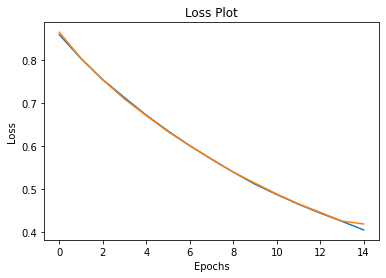

In [108]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Step 5 : Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [ ]:
#tf.expand_dims(load_image(image)[0], 0)

In [ ]:
#img_tensor_val
# img_tensor_val.shape[0]
# img_tensor_val.shape[3]

In [125]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

#     hidden = decoder.reset_state(batch_size=1)
    
    hidden = decoder.init_state(batch_size=1)

    # resuing the function to process the input image to desired format before extracting features as required by inception_v3
    temp_input = tf.expand_dims(load_image(image)[0], 0) 
    img_tensor_val = image_features_extract_model(temp_input)# Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)# get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()#extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id])#map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [ ]:
# def beam_evaluate(image, beam_index = #your value for beam index):

#     #write your code to evaluate the result using beam search
                  
#     return final_caption



In [111]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [112]:
from nltk.translate.bleu_score import sentence_bleu

In [136]:
def filt_text(text):
    filt=['<start>','<UNK>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

### Testing the model on random images from test dataset

In [143]:
#converting this block into a function

def generate_caption_audio(random,autoplay=False,weights=(0.5, 0.5, 0, 0)):
    rid = np.random.randint(0, len(path_test))
    test_image = path_test[rid]
    #test_image = './images/413231421_43833a11f5.jpg'
    #real_caption = '<start> black dog is digging in the snow <end>'

    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
    result, attention_plot,pred_test = evaluate(test_image)


    real_caption=filt_text(real_caption)      


    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    score = sentence_bleu(reference, candidate, weights=weights)
    print(f"BELU score: {score*100}")
    
    print(f'Real Caption:', {real_caption})
    print(f'Prediction Caption:', {pred_caption})
    plot_attmap(result, attention_plot, test_image)


#     Image.open(test_image)

    # Text to speech conversion APIs that are available are 
    #Googles gTTS , Amazon Polly, Microsoft Azure TTS
    #Using Google gTTS and playsound API to convert caption into audio
    speech = gTTS("Predicted Caption is: "+ pred_caption,lang = 'en', slow = False) 
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'
    #playsound('voice.wav')
    display.display(display.Audio(audio_file, rate=None,autoplay=autoplay))
                          
#     captions=beam_evaluate(test_image)
#     print(captions)

    return test_image

BELU score: 68.00874738944077
Real Caption: {'a determined girl is hitting a volleyball'}
Prediction Caption: {'a determined girl is practicing volleyball'}


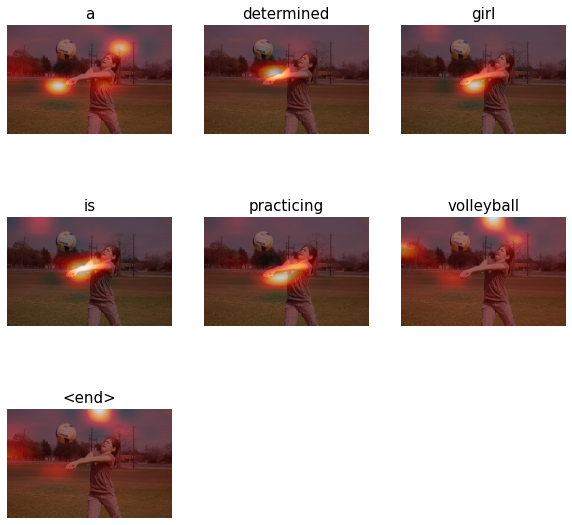

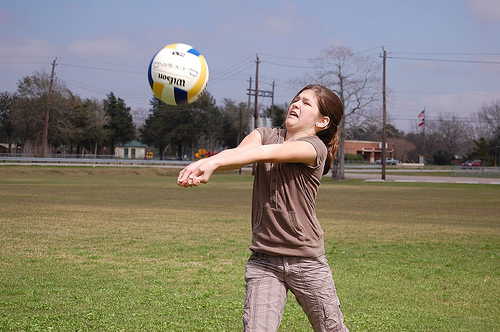

In [138]:
test_image=generate_caption_audio(5,True,weights=(0.5,0.25,0,0))

Image.open(test_image)

/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BELU score: 27.25230591784881
Real Caption: {'a girl wearing a headband is carrying a pink sign on the street'}
Prediction Caption: {'a girl is walking through the street'}


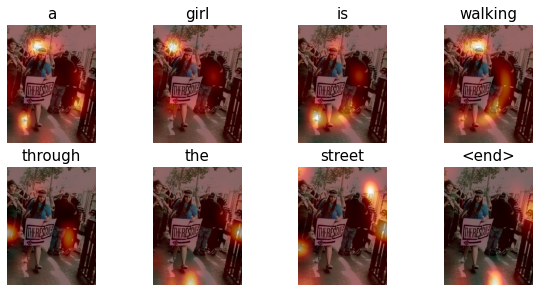

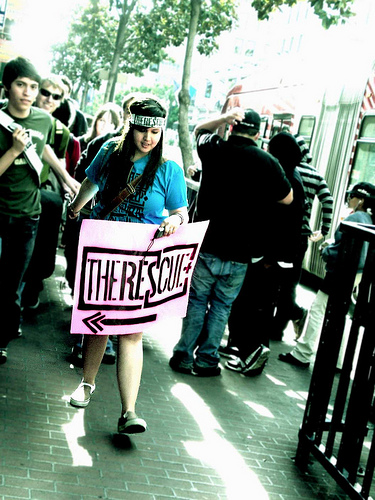

In [149]:
test_image=generate_caption_audio(5,True,weights=(0.5,0.25,0,0))

Image.open(test_image)

BELU score: 68.72892787909723
Real Caption: {'a row of people sitting on the ground wearing matching boots'}
Prediction Caption: {'a row of people sitting on the ground'}


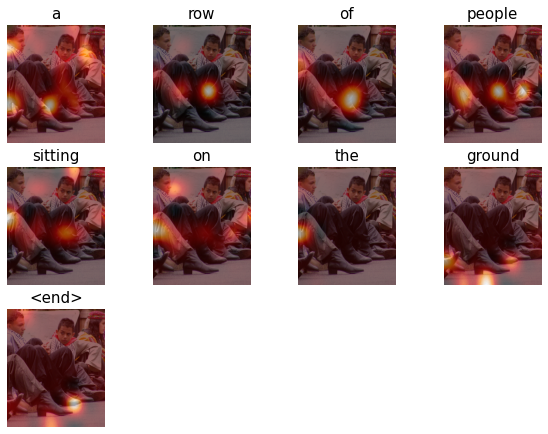

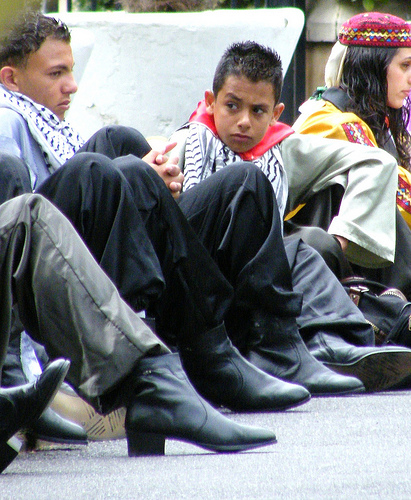

In [140]:
test_image=generate_caption_audio(5,True,weights=(0.5,0.25,0,0))

Image.open(test_image)

BELU score: 82.82522410375708
Real Caption: {'a lean dog runs through a wooded area'}
Prediction Caption: {'a dog runs through a wooded area'}


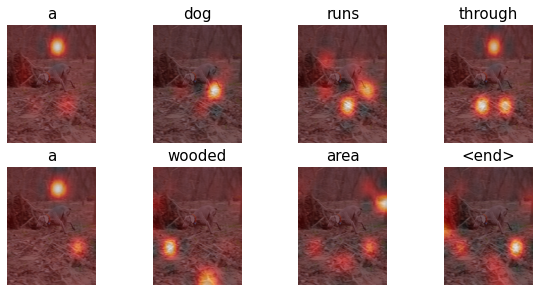

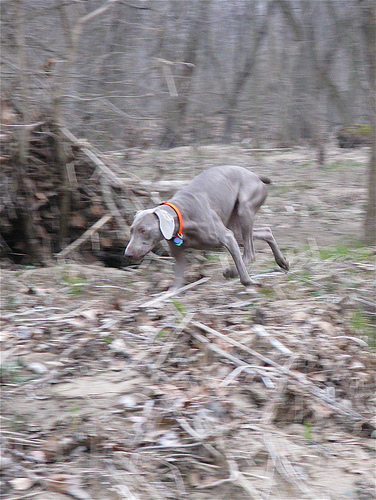

In [141]:
test_image=generate_caption_audio(5,True,weights=(0.5,0.25,0,0))

Image.open(test_image)

BELU score: 85.99476570625983
Real Caption: {'two children are rolling in muddy water'}
Prediction Caption: {'two children are rolling in deep muddy water'}


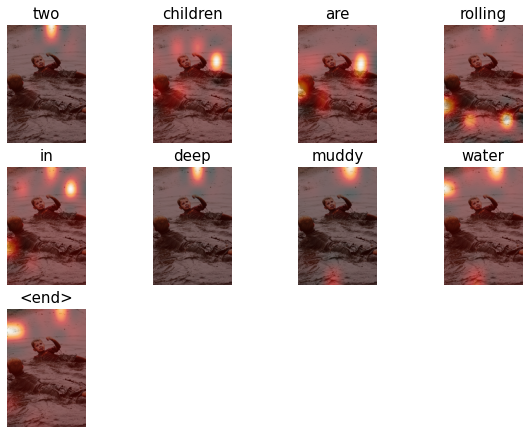

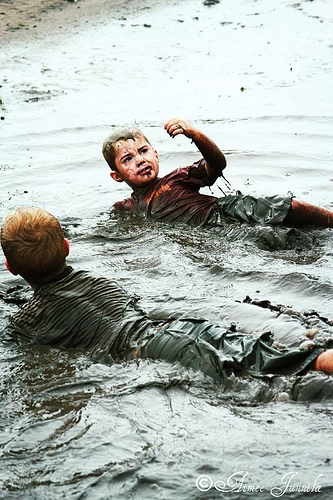

In [148]:
test_image=generate_caption_audio(5,True,weights=(0.5,0.25,0,0))

Image.open(test_image)

/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BELU score: 3.3074932606424605
Real Caption: {'a man in blue jeans sits on a bench near a woman in green pants with a red and white bus behind them'}
Prediction Caption: {'two people wait on a bench'}


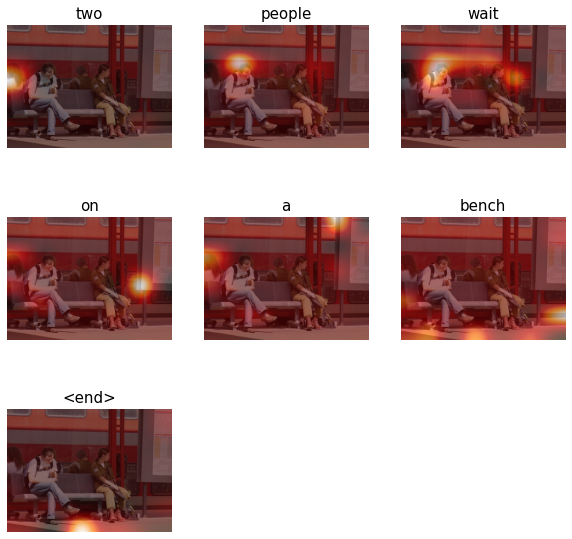

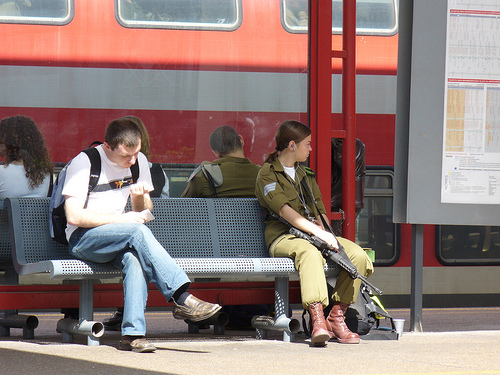

In [146]:
test_image=generate_caption_audio(5,True,weights=(0.5,0.25,0,0))

Image.open(test_image)

#### Inference : We got BELU score: 3.3 for the above image , model was not able to describe the accrate activity and colour of clothes of people in the image. Could train the model further to get them right

BELU score: 100.0
Real Caption: {'a white dog running through the snow'}
Prediction Caption: {'a white dog running through the snow'}


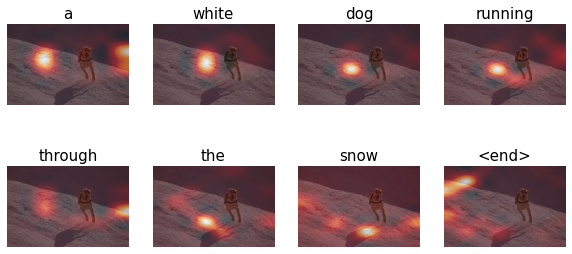

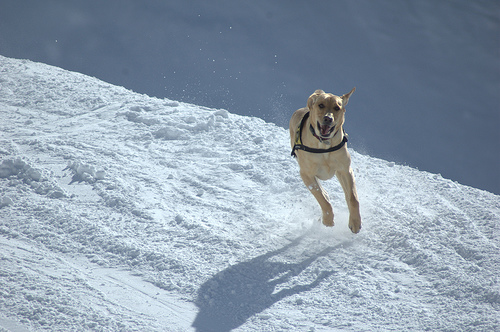

In [139]:
test_image=generate_caption_audio(5,True,weights=(0.5,0.25,0,0))

Image.open(test_image)

#### Inference : Model was able to generate 100% accurate caption for the above image

BELU score: 61.09777542133033
Real Caption: {'the black dog is walking through the dirt with a soccer ball in its mouth'}
Prediction Caption: {'a black dog is biting onto the soccer ball in its mouth'}


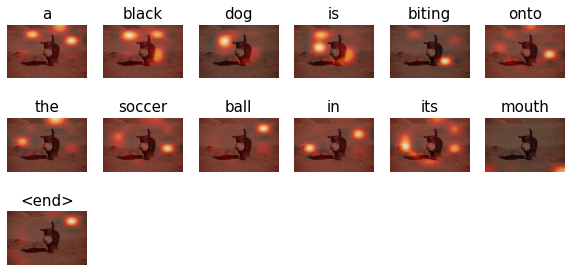

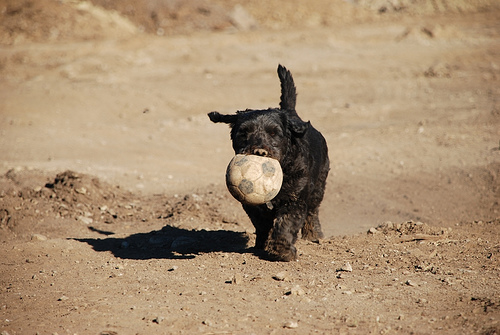

In [156]:
test_image=generate_caption_audio(len(path_test),True,weights=(0.5,0.25,0,0))

Image.open(test_image)

/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BELU score: 63.3160218956179
Real Caption: {'four children snow sledding down a hill'}
Prediction Caption: {'five children sledding down a snow covered hill'}


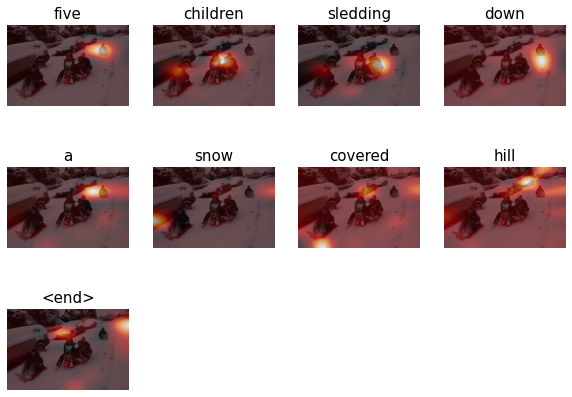

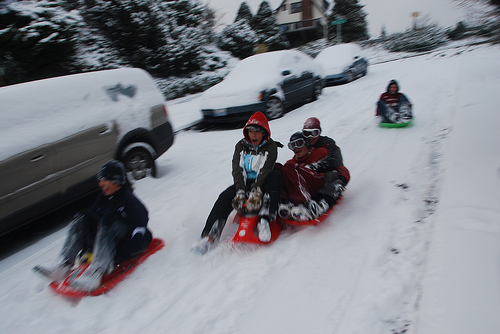

In [160]:
test_image=generate_caption_audio(4,True,weights=(0.5,0.25,0,0))

Image.open(test_image)

#### Inference : Apart from couple of images Model was able to generate >60% accurate caption for the images

### Conclusion :
- Successfully created the dataset according as required by Inception net V3 
- Used the pretrained Imagenet weights of Inception net V3
- Trained the model for 15 epochs and was able to reduce the loss to 0.420
- Used Greedy search for evalution
- Achieved >60% BELU score for most of the random images from test set on which model was tested